In [22]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import torch.optim as optim
from torch.autograd import Variable
from torch import FloatTensor, LongTensor
import joblib

In [23]:
selected_features = ['Destination Port', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                     'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                     'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 
                     'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
                     'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std',
                     'Bwd IAT Max', 'Bwd IAT Min', 'Min Packet Length', 'Max Packet Length', 
                     'Packet Length Mean', 'Packet Length Std', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 
                     'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count']

added_features = ['Fwd PSH Flags', 'Fwd URG Flags', 'Bwd PSH Flags', 'Bwd URG Flags']

#extra_features = ['Active Max', 'Idle Max' ]

computed_features = ['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Variance']

selected_features_total = (selected_features + 
                           added_features + 
                           computed_features)
    

In [24]:
class PreProcessor:
    def __init__(self, file_path, selected_features):
        self.input_dataset = pd.read_csv(file_path)
        self.selected_features = selected_features
        
    def print_input_data(self):
        print('The input dataset has the following columns/features')
        print(self.input_dataset.columns)
        labels = self.input_dataset['Label']
        print('The labels are as follows')
        print(labels.value_counts())
        print(labels.value_counts().plot.pie())
        
    def preprocess(self):
        X, y = self.feature_selection()
        X = self.imputing(X)
        X = self.scaling(X)
        y = self.label_binarization(y)
        self.data = torch.tensor(X)
        self.targets = torch.tensor(y)
        
    def feature_selection(self):
        X = self.input_dataset[self.selected_features]
        y = self.input_dataset['Label']
        return X, y
    
    def imputing(self, X):
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        Imp = SimpleImputer()
        X = Imp.fit_transform(X)
        return X
        
    def scaling(self, X):
        scaler = preprocessing.MinMaxScaler()
        X = scaler.fit_transform(X)
        joblib.dump(scaler, 'minmaxscaler')
        return X
    
    def label_binarization(self, y):
        for label in y:
            if (label != 'BENIGN' and label != 'ATTACK'):
                y.replace(label, 'ATTACK', inplace=True)
        y.replace('BENIGN', 1, inplace=True)
        y.replace('ATTACK', 0, inplace=True)
        return y
    
    def return_data(self):
        return self.data, self.targets

In [25]:
class MyDataset(Dataset):
    def __init__(self, file_path, selected_features):
        preprocessor = PreProcessor(file_path, selected_features)
        preprocessor.print_input_data()
        preprocessor.preprocess()
        self.data, self.targets = preprocessor.return_data()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data[idx]
        label = self.targets[idx]
        return row, label

In [26]:
num_epochs = 100

The input dataset has the following columns/features
Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Le

C:\Users\katsa\AppData\Local\Temp\ipykernel_15880\1543300877.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)


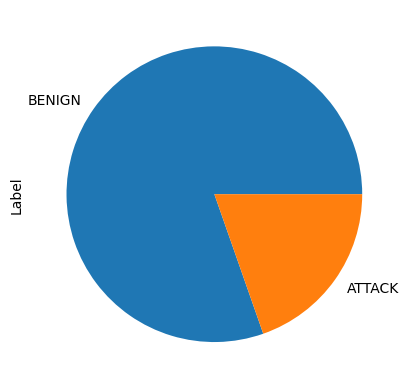

In [27]:
sample_path = "C:/Users/katsa/OneDrive/Jupyter_files/shallow_models_online/cic_train_sample_binary.csv"
CICDataset = MyDataset(sample_path, selected_features_total)
batch_size = 64
dataloader = DataLoader(CICDataset, batch_size=batch_size, 
                          shuffle=True, drop_last=True)

In [28]:
# Define the generator model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + 1, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 24),
            nn.BatchNorm1d(24, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(24, 32),
            nn.BatchNorm1d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 40),
            nn.BatchNorm1d(40, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, data_dim),
            nn.Sigmoid()
        )

    def forward(self, z, label):
        label = torch.full((batch_size, 1), label)
        z = torch.cat((noise, label), 1)
        data = self.model(z)
        return data
    


In [29]:
# Define the discriminator model

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, data):
        validity = self.model(data)
        return validity
    
    

In [30]:
# Definition of hyperparameters

data_dim=len(selected_features_total)
latent_dim = 8
print(data_dim)
lr = 0.0002
adversarial_loss = nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

47


In [31]:
noise = torch.randn(batch_size, latent_dim)

In [32]:
epochs_lst = [5, 10, 15, 20, 25, 30]

In [33]:
for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(dataloader):
        batch_size = data.shape[0]
        real_data = Variable(data.type(FloatTensor))        
        labels = Variable(labels.float())
        labels = labels.view(-1, 1).type(FloatTensor)
        
        # Train the discriminator
        optimizer_D.zero_grad()
        d_real_outputs = discriminator(real_data)
        d_real_loss = adversarial_loss(d_real_outputs, labels)
        
        fake_data = generator(noise, 0)
        d_fake_outputs = discriminator(fake_data.detach())
        d_fake_loss1 = adversarial_loss(d_fake_outputs, torch.full((batch_size, 1), 0.4).type(FloatTensor))
        
        fake_data = generator(noise, 1)
        d_fake_outputs = discriminator(fake_data.detach())
        d_fake_loss2 = adversarial_loss(d_fake_outputs, torch.full((batch_size, 1), 0.6).type(FloatTensor))
        
        d_loss = d_real_loss + d_fake_loss1 + d_fake_loss2
        d_loss.backward()
        optimizer_D.step()
        
        # Train the generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, latent_dim)
        fake_data = generator(noise, 0)
        d_fake_outputs = discriminator(fake_data)
        targets = torch.full((batch_size, 1), 0)
        g_loss1 = adversarial_loss(d_fake_outputs, targets.float())

        noise = torch.randn(batch_size, latent_dim)
        fake_data = generator(noise, 1)
        d_fake_outputs = discriminator(fake_data)
        targets = torch.full((batch_size, 1), 1)
        g_loss2 = adversarial_loss(d_fake_outputs, targets.float())
        
        g_loss = g_loss1 + g_loss2
        g_loss.backward()
        optimizer_G.step()
        

        # Print the loss for each epoch
        if i % 1000 == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))

    print('Saving models...')
    # save discriminator model used for classification
    PATH_disc = './models/discr_model-'
    PATH = PATH_disc + 'lr=' + str(lr) + '-batch=' + str(batch_size) + '-epochs=' + str(epoch) + '.pth'
    torch.save(discriminator.state_dict(), PATH)
    
    # save generator model
    PATH_gen = './models/gen_model-'
    PATH = PATH_gen + 'lr=' + str(lr) + '-batch=' + str(batch_size) + '-epochs=' + str(epoch) + '.pth'
    torch.save(generator.state_dict(), PATH)

[Epoch 0/100] [Batch 0/2211] [D loss: 2.028075] [G loss: 1.402511]
[Epoch 0/100] [Batch 1000/2211] [D loss: 1.677869] [G loss: 1.069430]
[Epoch 0/100] [Batch 2000/2211] [D loss: 1.562885] [G loss: 0.937651]
Saving models...
[Epoch 1/100] [Batch 0/2211] [D loss: 1.591988] [G loss: 0.944359]
[Epoch 1/100] [Batch 1000/2211] [D loss: 1.573730] [G loss: 0.921671]
[Epoch 1/100] [Batch 2000/2211] [D loss: 1.664149] [G loss: 0.853418]
Saving models...
[Epoch 2/100] [Batch 0/2211] [D loss: 1.577153] [G loss: 0.842461]
[Epoch 2/100] [Batch 1000/2211] [D loss: 1.627570] [G loss: 0.852552]
[Epoch 2/100] [Batch 2000/2211] [D loss: 1.617634] [G loss: 0.846683]
Saving models...
[Epoch 3/100] [Batch 0/2211] [D loss: 1.630180] [G loss: 0.851040]
[Epoch 3/100] [Batch 1000/2211] [D loss: 1.671743] [G loss: 0.831465]
[Epoch 3/100] [Batch 2000/2211] [D loss: 1.684411] [G loss: 0.823968]
Saving models...
[Epoch 4/100] [Batch 0/2211] [D loss: 1.662930] [G loss: 0.819033]
[Epoch 4/100] [Batch 1000/2211] [D lo